In [1]:
import copy
import os
import time
import sqlalchemy
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from dotenv import load_dotenv
import xetcache

from cities.deployment.tracts_minneapolis.predict import TractsModelPredictor
from cities.utils.data_loader import db_connection

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_model import TractsModel

from cities.modeling.zoning_models.zoning_tracts_population import TractsModelPopulation
from cities.modeling.zoning_models.zoning_tracts_continuous_interactions_model import TractsModelContinuousInteractions
from cities.utils.data_loader import select_from_data, ZoningDataset
from cities.modeling.waic import compute_waic


from cities.utils.data_grabber import find_repo_root

from cities.modeling.svi_inference import run_svi_inference
from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm

from cities.utils.data_loader import select_from_sql


root = find_repo_root()


smoke_test = "CI" in os.environ
n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000


        Usage:

           %%xetmemo input=v1,v2 output=v3,v4

        Caches the specified output variables each time it is called.
        If called later with the same inputs , the cached value is returned
        and not reevaluated. This is persistent across Python runs.

        Any content changes to the input input variables, or cell code will
        force reevaluation of the cell. Otherwise the outputs will simply be
        retrieved from the memo.

        This memo is persistent across Python processes and if XetHub is used
        see `xetcache.set_xet_project`, can be shared with others.

        For performance reasons, only functions which take more than 3
        seconds (configurable from config.set_runtime_threshold) will be 
        cached. "always=True" can be added to the xetmemo arguments to
        ignore the runime and to always cache

           %%xetmemo input=v1,v2 output=v3,v4 always=True

        Note that inputs can be anything picklable including funct

In [2]:

census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path, weights_only=False)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract", 'university_index', 'downtown_index'],
    "continuous": {
        "housing_units",
        "housing_units_original",
        "total_value",
        "total_population",
        "population_density",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        'limit',
        "segregation_original",
        "white_original",
        "parcel_sqm",
        'downtown_overlap', 
        'university_overlap',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

print(subset['continuous'].keys())

dict_keys(['mean_limit_original', 'median_distance', 'total_value', 'median_value', 'housing_units', 'parcel_sqm', 'income', 'housing_units_original', 'segregation_original', 'total_population', 'university_overlap', 'population_density', 'white_original', 'downtown_overlap'])


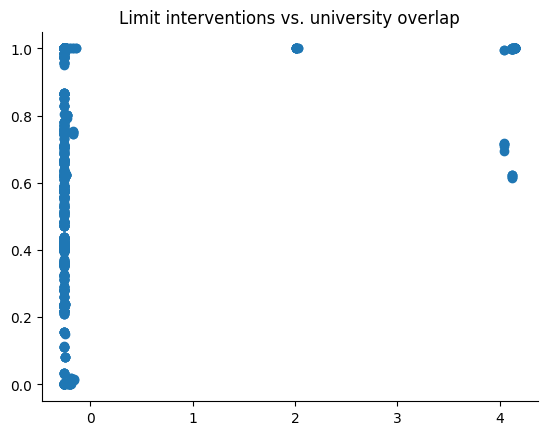

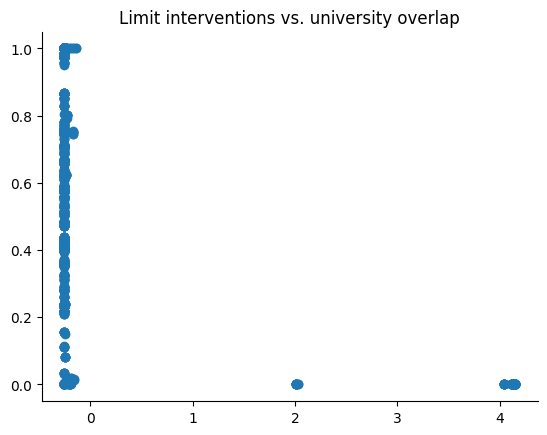

In [3]:


plt.scatter(subset['continuous']['university_overlap'], subset['continuous']['mean_limit_original'], label='observed')
sns.despine()
plt.title('Limit interventions vs. university overlap')
plt.show()

# set to zero whenever the university overlap is above 1
subset['continuous']['mean_limit_original'] = torch.where(subset['continuous']['university_overlap'] > 1, 
                                                          torch.zeros_like(subset['continuous']['mean_limit_original']), 
                                                          subset['continuous']['mean_limit_original'])


plt.scatter(subset['continuous']['university_overlap'], subset['continuous']['mean_limit_original'], label='observed')
sns.despine()
plt.title('Limit interventions vs. university overlap')
plt.show()


In [4]:

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


In [5]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


[iteration 0001] loss: 315099.3125
[iteration 0050] loss: 30909.0508
[iteration 0100] loss: 19187.3594
[iteration 0150] loss: 21331.4043
[iteration 0200] loss: 15945.8975
[iteration 0250] loss: 16054.9414
[iteration 0300] loss: 15585.8916
[iteration 0350] loss: 14877.6953
[iteration 0400] loss: 15025.9961
[iteration 0450] loss: 14780.5264
[iteration 0500] loss: 14712.0957
[iteration 0550] loss: 14685.3564
[iteration 0600] loss: 14670.9297
[iteration 0650] loss: 14669.9873
[iteration 0700] loss: 14687.9639
[iteration 0750] loss: 14541.6250
[iteration 0800] loss: 14568.9502
[iteration 0850] loss: 14572.0146
[iteration 0900] loss: 14437.0986
[iteration 0950] loss: 14532.0908
[iteration 1000] loss: 14420.1143
[iteration 1050] loss: 14439.1426
[iteration 1100] loss: 14391.6436
[iteration 1150] loss: 14368.9736
[iteration 1200] loss: 14330.4893
[iteration 1250] loss: 14523.8818
[iteration 1300] loss: 14382.5371
[iteration 1350] loss: 14340.8887
[iteration 1400] loss: 14254.4580
[iteration 14

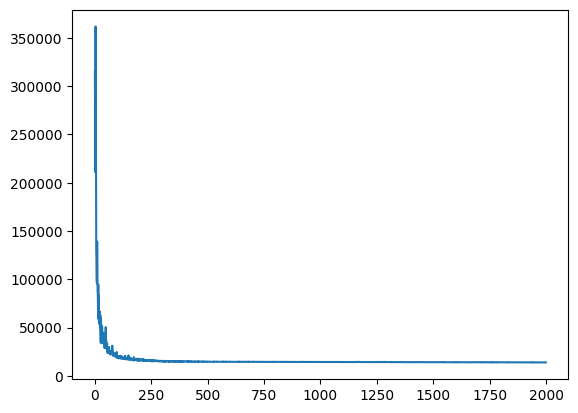

tensor(2752.8391, grad_fn=<MulBackward0>)


In [6]:

ins = [
    ("university_overlap", "limit"),
    ("downtown_overlap", "limit"),
    ("distance", "downtown_overlap"),
    ("distance", "university_overlap"),
    ("distance", "limit"),
    ("median_value", "segregation"),
    ("distance", "segregation"),
    ("limit", "sqm"),
    ("segregation", "sqm"),
    ("distance", "white"),
    ("income", "limit"),
    ("downtown_overlap", "median_value"),
    ("downtown_overlap", "segregation"),
    ("median_value", "white"),
    ("distance", "income"),
    # from density/pop stage 1
    ('population', 'sqm'), 
    ('density', 'income'), ('density', 'white'), 
    ('density', 'segregation'), ('density', 'sqm'), 
    ('density', 'downtown_overlap'), ('density', 'university_overlap'), 
    ('population', 'density')
]

pyro.clear_param_store()

tracts_model = TractsModelPopulation(
    **subset,
    housing_units_continuous_interaction_pairs = ins
)


pyro.clear_param_store()
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

waic = compute_waic(
    model=tracts_model,
    guide=guide,
    num_particles=10000,
    sites=["housing_units"],
    max_plate_nesting=9,
    **subset,
)

print(waic['waic']) 

predictive = Predictive(tracts_model, guide=guide, num_samples=1000)
population_preds = predictive(**subset_for_preds)


In [7]:
# population_preds_path = "population_preds.dill"
sqm_preds_path = "sqm_preds.dill"
interaction_preds_path = "interactions_preds.dill"

# with open(population_preds_path, "rb") as f:
#     population_preds = dill.load(f)

with open(sqm_preds_path, "rb") as f:
    sqm_preds = dill.load(f)

with open(interaction_preds_path, "rb") as f:
    interactions_preds = dill.load(f)


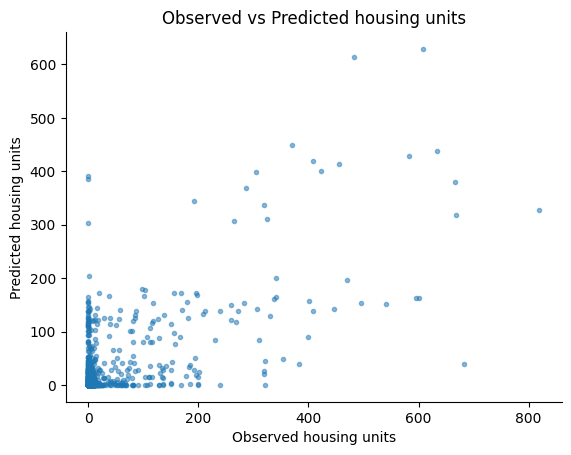

In [8]:

pop_preds_units = destandardize_housing_units(population_preds["housing_units"])
pop_preds_units_mean = pop_preds_units.mean(dim=0).clamp(min = 0).detach().numpy()
units_observed_original = subset['continuous']['housing_units_original'].detach().numpy()

plt.scatter(y = pop_preds_units_mean ,
             x = units_observed_original, s= 9, alpha = .5)
plt.xlabel("Observed housing units")
plt.ylabel("Predicted housing units")
plt.title("Observed vs Predicted housing units")
sns.despine()
plt.show()

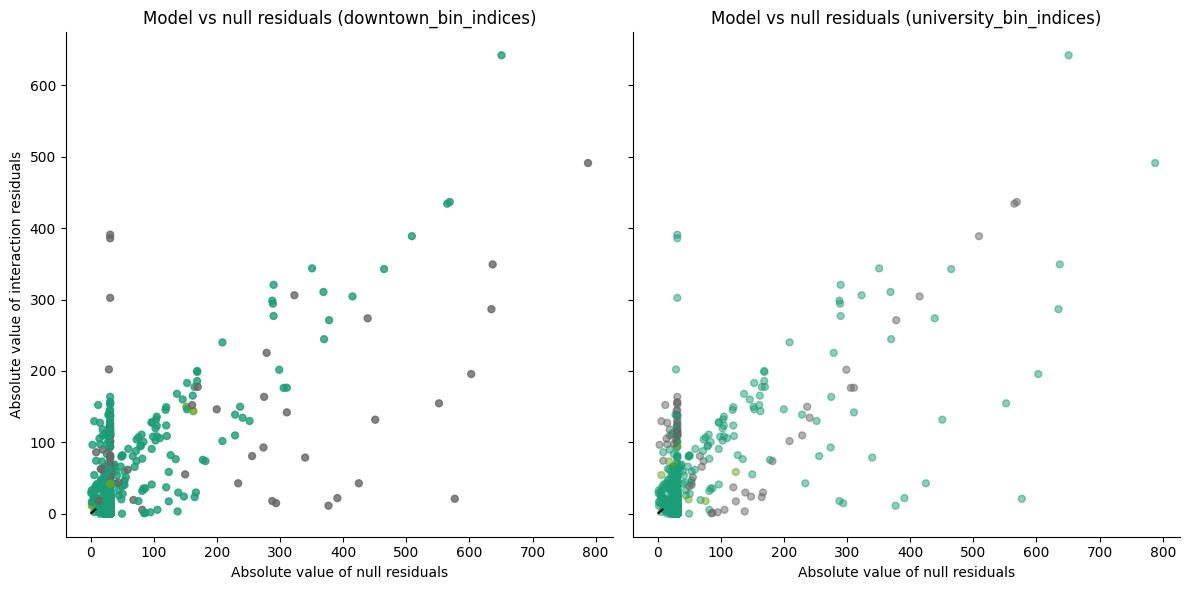

In [9]:

pop_residuals = units_observed_original - pop_preds_units_mean
null_residuals = units_observed_original  - np.mean(units_observed_original)
bins = [-np.inf, 0, 3, np.inf]  # Representing university_overlap < 0, 
# 0 < university_overlap < 3, and university_overlap >= 3
bin_labels = ['< 0', '0-3', '>= 3']

university_overlap = subset['continuous']['university_overlap'].detach().numpy()
downtown_overlap = subset['continuous']['downtown_overlap'].detach().numpy()
university_bin_indices = np.digitize(university_overlap, bins=bins) - 1 
downtown_bin_indices = np.digitize(downtown_overlap, bins=bins) - 1


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].scatter(x=abs(null_residuals), y=abs(pop_residuals),
                 s=25, alpha=0.8, c=downtown_bin_indices, cmap = 'Dark2')
axes[0].set_xlabel("Absolute value of null residuals")
axes[0].set_ylabel("Absolute value of interaction residuals")
axes[0].plot([0, 9], [0, 7], 'k--')
axes[0].set_title("Model vs null residuals (downtown_bin_indices)")

axes[1].scatter(x=abs(null_residuals), y=abs(pop_residuals), 
                s=25, alpha=0.5, c=university_bin_indices, cmap = "Dark2")
axes[1].set_xlabel("Absolute value of null residuals")
axes[1].plot([0, 9], [0, 7], 'k--')
axes[1].set_title("Model vs null residuals (university_bin_indices)")

plt.tight_layout()
sns.despine()
plt.show()

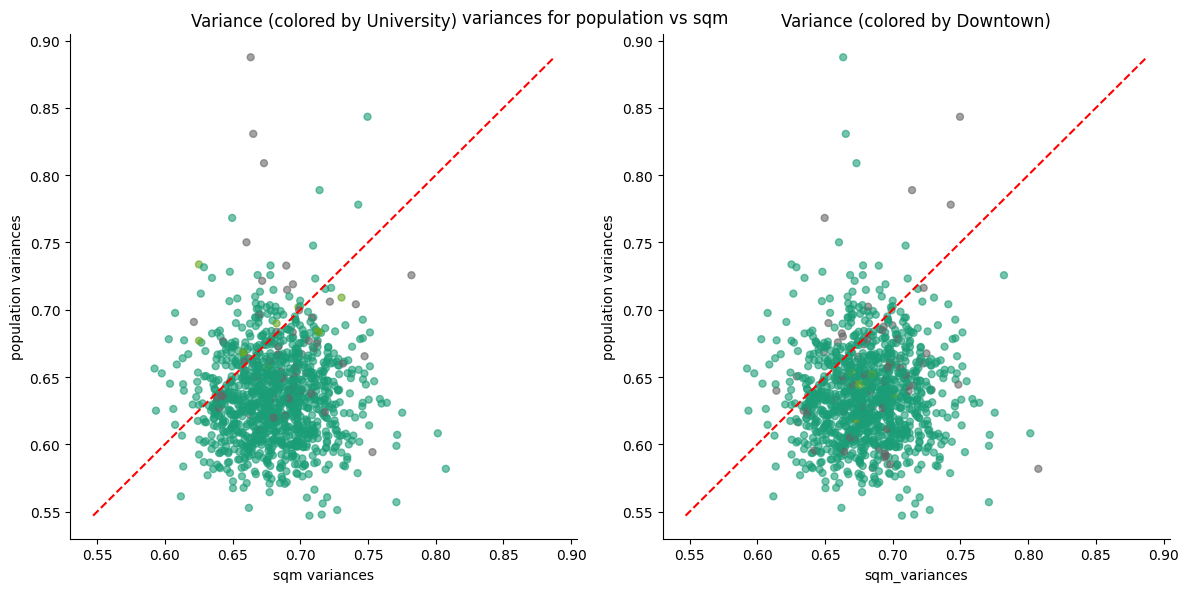

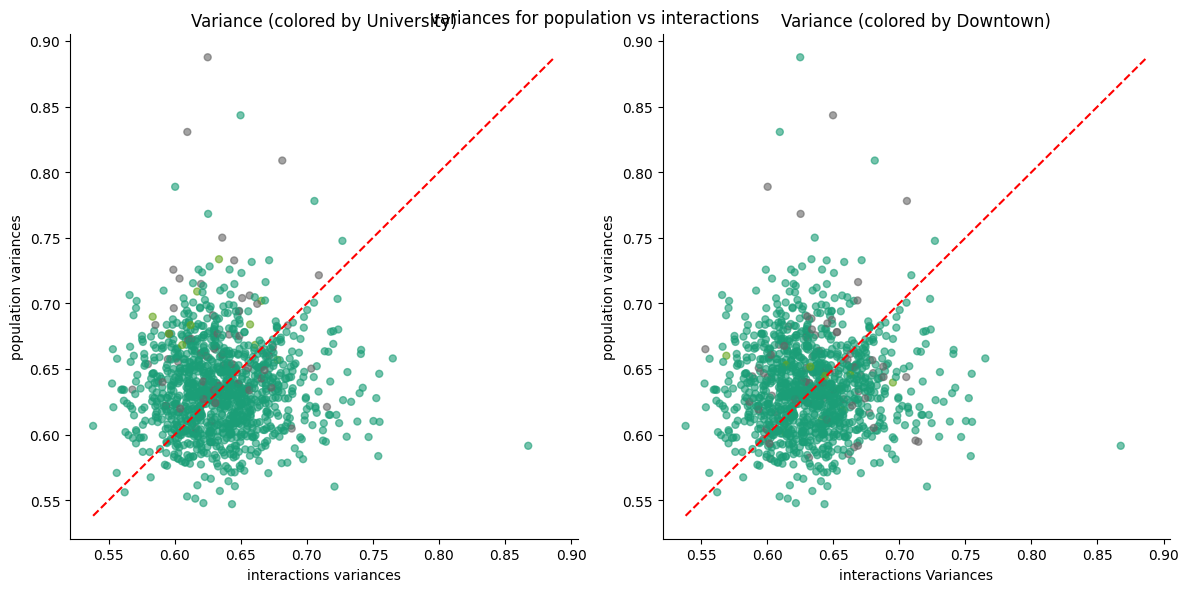

In [10]:

# by University - a bit more variance, but much better than before
pop_variances = population_preds['housing_units'].var(dim=0)
sqm_variances = sqm_preds['housing_units'].var(dim=0)
interaction_variances = interactions_preds['housing_units'].var(dim=0)  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

scatter1 = axes[0].scatter(y=pop_variances, x=sqm_variances, 
                           c=university_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), sqm_variances.min())
max_val = max(pop_variances.max(), sqm_variances.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[0].set_ylabel("population variances")
axes[0].set_xlabel("sqm variances")
axes[0].set_title("Variance (colored by University)")

#by Downtown
scatter2 = axes[1].scatter(y=pop_variances, x=sqm_variances, 
                           c=downtown_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), sqm_variances.min())
max_val = max(pop_variances.max(), sqm_variances.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[1].set_ylabel("population variances")
axes[1].set_xlabel("sqm_variances")
axes[1].set_title("Variance (colored by Downtown)")
sns.despine()
plt.tight_layout()

plt.suptitle("variances for population vs sqm")
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

scatter1 = axes[0].scatter(y=pop_variances, x=interaction_variances, 
                           c=university_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), interaction_variances.min())
max_val = max(pop_variances.max(), interaction_variances.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[0].set_ylabel("population variances")
axes[0].set_xlabel("interactions variances")
axes[0].set_title("Variance (colored by University)")

#by Downtown
scatter2 = axes[1].scatter(y=pop_variances, x=interaction_variances, 
                           c=downtown_bin_indices, s=25, alpha=0.6,
                           cmap = "Dark2")
min_val = min(pop_variances.min(), interaction_variances.min())
max_val = max(pop_variances.max(), interaction_variances.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

axes[1].set_ylabel("population variances")
axes[1].set_xlabel("interactions Variances")
axes[1].set_title("Variance (colored by Downtown)")
sns.despine()
plt.tight_layout()

plt.suptitle("variances for population vs interactions")
plt.show()



In [11]:
# count extreme prediction failures, cases where obs are beyond 99% intervals
units_observed = subset['continuous']['housing_units'].detach().numpy()

quantiles = population_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)

pop_outliers_below = (torch.tensor(units_observed) < quantiles[0,:]).sum()
pop_outliers_above = (torch.tensor(units_observed) > quantiles[1,:]).sum()

print(pop_outliers_below, pop_outliers_above, (pop_outliers_below + pop_outliers_above)/units_observed.shape[-1])


sqm_quantiles = sqm_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)
sqm_outliers_above = (torch.tensor(units_observed) > sqm_quantiles[1,:]).sum()
sqm_outliers_below = (torch.tensor(units_observed) < sqm_quantiles[0,:]).sum()

print(sqm_outliers_below, sqm_outliers_above, (sqm_outliers_below + sqm_outliers_above)/units_observed.shape[-1])

interactions_quantiles = interactions_preds['housing_units'].quantile(torch.tensor([0.005, 0.995]), dim=0)
interaction_outliers_above = (torch.tensor(units_observed) > interactions_quantiles[1,:]).sum()
interaction_outliers_below = (torch.tensor(units_observed) < interactions_quantiles[0,:]).sum()

print(interaction_outliers_below, interaction_outliers_above, (interaction_outliers_below + interaction_outliers_above)/units_observed.shape[-1])


tensor(4) tensor(27) tensor(0.0274)
tensor(10) tensor(52) tensor(0.0549)
tensor(20) tensor(52) tensor(0.0637)


[iteration 0001] loss: 202172.1562
[iteration 0050] loss: 48092.0078
[iteration 0100] loss: 22922.2051
[iteration 0150] loss: 20431.8945
[iteration 0200] loss: 17747.7832
[iteration 0250] loss: 13755.0029
[iteration 0300] loss: 12603.3154
[iteration 0350] loss: 11699.9180
[iteration 0400] loss: 11778.7842
[iteration 0450] loss: 10586.5000
[iteration 0500] loss: 10566.5674
[iteration 0550] loss: 9875.4141
[iteration 0600] loss: 9778.3271
[iteration 0650] loss: 9846.2363
[iteration 0700] loss: 9701.5752
[iteration 0750] loss: 9401.3945
[iteration 0800] loss: 9290.4238
[iteration 0850] loss: 9544.8037
[iteration 0900] loss: 9169.1934
[iteration 0950] loss: 9267.2920
[iteration 1000] loss: 9254.5723
[iteration 1050] loss: 9080.1592
[iteration 1100] loss: 9128.6572
[iteration 1150] loss: 9056.9385
[iteration 1200] loss: 9020.5596
[iteration 1250] loss: 9108.2100
[iteration 1300] loss: 8997.6982
[iteration 1350] loss: 9024.4854
[iteration 1400] loss: 8943.8145
[iteration 1450] loss: 8899.973

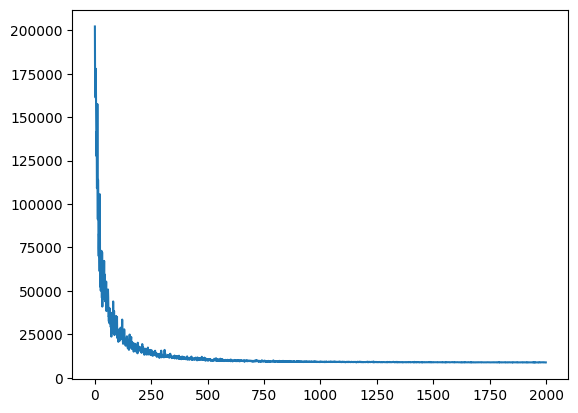

/home/rafal/s78projects/cities/cities/modeling/zoning_models/zoning_tracts_population.py:66: UserWarning: Passed categorical_levels will no longer override the levels passed to or computed during model initialization. The argument will be ignored.
  warnings.warn(


tensor(0.4923) tensor(0.0967)


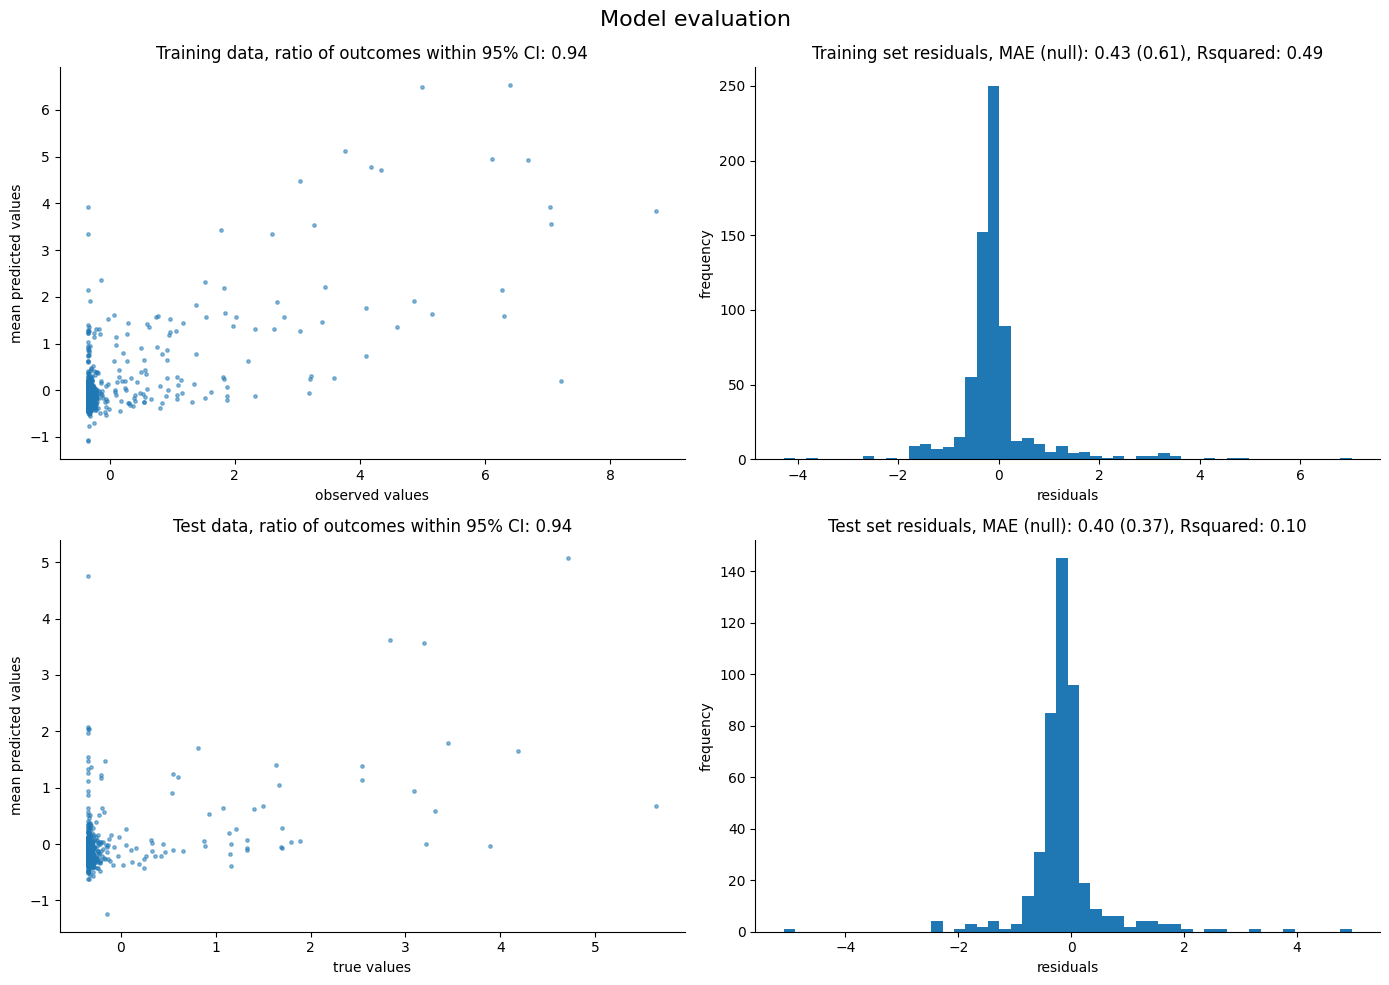

MAE improvements on the original scale: (tensor(29.), tensor(47.))
Writing to 63682dc453a772c6f7d97e93f411bbc35f0bb660f92c0b53524ba1079b4382f8.pickle


In [12]:
%%xetmemo input=tracts_model output=performance_results

pyro.clear_param_store()

train_loader, test_loader, categorical_levels = prep_data_for_test(
    census_tracts_data_path, train_size=0.6
)

performance_results = test_performance(
    tracts_model,
    kwargs,
    train_loader,
    test_loader,
    categorical_levels,
    outcome_type="continuous",
    outcome_name="housing_units",
    n_steps=n_steps,
    plot=True,
    is_class=False,
)

def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


mae_improvement_train = destandardize_housing_units(
    performance_results["mae_null_train"] - performance_results["mae_train"]
)
mae_improvement_test = destandardize_housing_units(
    performance_results["mae_null_test"] - performance_results["mae_test"]
)

print(
    f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
)